In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style 
from nnfs.datasets import spiral_data
import nnfs

style.use("dark_background")

# Neural Network Batch Load Example

In [2]:
inputs = [[1.0, 2.0, 3.0, 2.5],\
          [2.0, 5.0, -1.0, 2.0],\
          [-1.5, 2.7, 3.3, -0.8]]

#hidden layer 1
weights = [[0.2, 0.8, -0.5, 1.0],\
           [0.5, -0.91, 0.26, -0.5],\
           [-0.26, -0.27, 0.17, 0.87]]
biases = [2, 3, 0.5]

layer1_outputs = np.dot(inputs, np.array(weights).T) + biases

## output layout ##
#columns = Neurons
#rows = SampleResultants
print(layer1_outputs)

[[ 4.8    1.21   2.385]
 [ 8.9   -1.81   0.2  ]
 [ 1.41   1.051  0.026]]


In [3]:
weights2 = [[0.1, -0.14, 0.5],\
            [-0.5, 0.12, -0.33],\
            [-0.44, 0.73, -0.13]]
biases = [-1, 2, -0.5]

layer2_outputs = np.dot(layer1_outputs, np.array(weights2).T) + biases
print(layer2_outputs)

[[ 0.5031  -1.04185 -2.03875]
 [ 0.2434  -2.7332  -5.7633 ]
 [-0.99314  1.41254 -0.35655]]


# Mock data for neural network

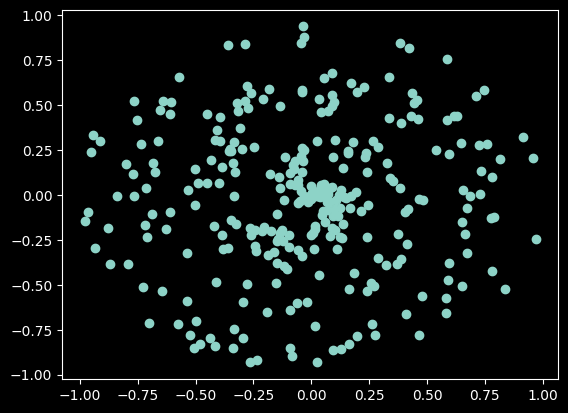

In [4]:
nnfs.init()

X, y = spiral_data(samples=100, classes=3)
plt.scatter(X[:,0], X[:,1])
plt.show()

## Mock Data class plot

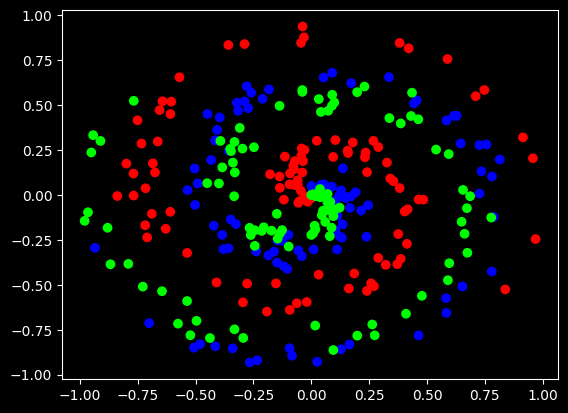

In [5]:
plt.scatter(X[:,0], X[:,1], c=y, cmap='brg')
plt.show()

# Neural Network Code

## Dense Layer Class

In [108]:
class Layer_Dense:
    
    #Layer initialization
    def __init__(self, n_inputs, n_neurons,\
                 weight_lambda_l1=0, weight_lambda_l2=0,\
                 bias_lambda_l1=0, bias_lambda_l2=0):
        #initialize weights and biases
        self.weights = 0.1 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        
        #set regularization strength (lambda)
        self.weight_lambda_l1 = weight_lambda_l1
        self.weight_lambda_l2 = weight_lambda_l2
        self.bias_lambda_l1 = bias_lambda_l1
        self.bias_lambda_l2 = bias_lambda_l2
    
    #Forward Pass
    def forward(self, inputs):
        #remember input values
        self.inputs = inputs
        #calculate output values from inputs, weights, and biases
        self.output = np.dot(inputs, self.weights) + self.biases
        
    #Backward Pass
    def backward(self, dvalues):
        #gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        #gradients on regularization
        #L1 on weights
        if self.weight_lambda_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_lambda_l1 * dl1
        #L2 on weights
        if self.weight_lambda_l2 > 0:
            self.dweights += 2 * self.weight_lambda_l2 * \
                            self.weights
        #L1 on biases
        if self.bias_lambda_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_lambda_l1 * dL1
        #L2 on biases
        if self.bias_lambda_l2 > 0:
            self.dbiases += 2 * self.bias_lambda_l2 * \
                            self.biases
        
        #gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)
    

## ReLU activation function class

In [7]:
#ReLu code
class ReLU_Activation:
    def forward(self, inputs):
        #ReLu function:
        # y = x : x > 0
        # y = 0 : x <= 0
        #calculate maximum values from input
        self.inputs = inputs
        self.output = np.maximum(0,inputs)
        
    def backward(self, dvalues):
        #original variable will be modified. make a copy
        self.dinputs = dvalues.copy()
        
        #zero gradients where input values are equal to or less than 0
        self.dinputs[self.inputs <= 0] = 0

### Dense layer 1 forward pass

In [8]:
dense1 = Layer_Dense(2, 3) #2 input values per feature set & 3 output values (1 per neuron)
dense1.forward(X)
print(dense1.output[:5]) #print partial. full will be 100 rows (100 feature sets) x 3 columns (3 neurons)

[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [-1.0475188e-04  1.1395361e-04 -4.7983500e-05]
 [-2.7414842e-04  3.1729150e-04 -8.6921798e-05]
 [-4.2188365e-04  5.2666257e-04 -5.5912682e-05]
 [-5.7707680e-04  7.1401405e-04 -8.9430439e-05]]


### Dense layer 1 outputs pass through ReLU Activation

In [9]:
#apply activation function to dense layer1 output
activation1 = ReLU_Activation() #create ReLu activation (to be used with dense layer)
activation1.forward(dense1.output) #make forward pass through activation function. takes output from 1st layer
print(activation1.output[:5])

[[0.         0.         0.        ]
 [0.         0.00011395 0.        ]
 [0.         0.00031729 0.        ]
 [0.         0.00052666 0.        ]
 [0.         0.00071401 0.        ]]


### Example: hardcoded Soft Max function

In [10]:
#Softmax = e^Z_i,j / Sum_l=1->L(e^Z_i,l) 
#Output: Normalized probability distribution for classes. Returns confidence scores for each class

prac_layer_outputs = [4.8, 1.21, 2.385]
E = 2.71828182846 #mathematical constant e

#for each value in a vector, calculate the exponential value
prac_exp_values = []
for ouput in prac_layer_outputs:
    prac_exp_values.append(E**ouput)
print("exponentiated values:")
print(prac_exp_values)

exponentiated values:
[121.51041751893969, 3.3534846525504487, 10.85906266492961]


In [11]:
norm_base = sum(prac_exp_values) #Sum l=1->L(e^Z_i,l)
norm_values = []

for value in prac_exp_values:
    norm_values.append(value/norm_base)
print("normalzed values")
print(norm_values)
print(sum(norm_values)) #shows all scores will add up to 1.0 

normalzed values
[0.8952826639573506, 0.024708306782070668, 0.08000902926057876]
1.0


### Example: Softmax function with numpy

In [12]:
norm_base = []
norm_values = []
prac_exp_values = []

prac_exp_values = np.exp(prac_layer_outputs) #exponential value of each value
print("prac_exp_values", prac_exp_values)

norm_values = prac_exp_values / sum(prac_exp_values)
print("normalzed values & Sum", norm_values, sum(norm_values))

prac_exp_values [121.51041752   3.35348465  10.85906266]
normalzed values & Sum [0.89528266 0.02470831 0.08000903] 0.9999999999999999


## Softmax Activation Function Class

In [13]:
class Activation_Softmax:
    def forward(self, inputs):
        #Softmax = e^Z_i,j / Sum_l=1->L(e^Z_i,l) 
        #Output: Normalized probability distribution for classes. Returns confidence scores for each class
        self.inputs = inputs
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True)) #combat dead neurons & exploding values
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        
    def backward(self, dvalues):
        #uninitialized array
        self.dinputs = np.empty_like(dvalues)
        
        #enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            #flatten output array
            single_output = single_output.reshape(-1, 1)
            
            #calculate Jacobian matrix of output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            
            #Calculate sample-wise gradient and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

### Example: use of Softmax class 

In [14]:
softmax = Activation_Softmax()
softmax.forward([[1,2,3]])
print(softmax.output)

[[0.09003057 0.24472847 0.66524096]]


## Dense layer 2 takes output from ReLU and forward passes

In [15]:
# 3 input features, 3 outputs (3 ouput features from pervious layer, 3 neurons in dense2)
dense2 = Layer_Dense(3,3)

# make forward pass through 2nd layer with ReLU activation output 
dense2.forward(activation1.output) 

### Dense Layer 2 output from ReLU passes through Softmax activation
!!!! Section not used. Replaced by combination function Activation_Softmax_Loss_CategoricalCrossEntropy() !!!!

In [16]:
#activation2 = Activation_Softmax() #create softmax activation (to be used with dense layer)
#activation2.forward(dense2.output) #make forward pass through activation function. takes output of 2nd dense layer
#print(activation2.output[:5])

## Common Loss Class:
### Common operations are performed for loss functions. One of these operations is calculating the overall loss

In [17]:
#common loss class
class Loss:
    #regularization loss calculation
    def regularization_loss(self, layer):
        #0 by defalut
        regularization_loss = 0
        
        #L1 regularization - weights
        #calculate only when factor greater than 0
        if layer.weight_lambda_l1 > 0:
            regularization_loss += layer.weight_lambda_l1 *\
                                    np.sum(np.abs(layer.weights))
        #l2 regularization - weights
        if layer.weight_lambda_l2 > 0:
            regularization_loss += layer.weight_lambda_l2 *\
                                    np.sum(layer.weights * layer.weights)
                
        #l1 regularization - biases
        #calculate if > 0
        if layer.bias_lambda_l1 > 0:
            regularization_loss += layer.bias_lambda_l1 *\
                                    np.sum(np.abs(layer.biases))
        #l2 regularization - biases
        if layer.bias_lambda_l2 > 0:
            regularization_loss += layer.bias_lambda_l2 *\
                                    np.sum(layer.biases * layer.biases)
            
        return regularization_loss
    
    #claculate the data and regularization losses
    #given model output and ground truths (y_pred, y_target)
    def calculate(self, output, y):
        
        #calculate sample loses using the loss functions class
        sample_losses = self.forward(output, y)
        
        #calculate mean loss
        data_loss =  np.mean(sample_losses)
    
        #return loss
        return data_loss

## Categorical Cross Entropy Class

In [18]:
#Cross Entropy Loss
#inherits the "Loss" class
class Loss_CategoricalCrossEntropy(Loss):
    
    #forward pass
    def forward(self, y_pred, y_true):
        #number of samples in the batch (j)
        num_samples = len(y_pred)
               
        #Li = -SUM_j(Y_true_i,j * log(Y_pred_i,j))
        
        #Li = sample loss value
        #i = i-th sample in the set
        #j = label/output index
        #Y_true = target values
        #Y_pred = predicted values
        #           _i_
        #       0   1  2
        #  |0  [[1, 2, 3,],
        #j |1   [4, 5, 6,],
        #  |2   [7, 8, 9]]
        

        #clip data to prevent division by 0
        #clip data on both sides to prevent altering mean to either side
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        #Use Case 1: 
        #get probabilites for target values if categorical labels (sparse)
        if(len(y_true.shape) == 1):
            correct_confidences = y_pred_clipped[range(num_samples), y_true]
          
        #Use Case 2:
        #get probabilites from distribution for target values when target labels are one-hot encoded
        #multipy by 0 to drop non-targets
        #multiply by 1 to keep target probability
        elif(len(y_true.shape) == 2):
            correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)
            
        #losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues) #number of samples
        
        #number of labels in every sample
        #use the first sample to count them.
        labels = len(dvalues[0])
        
        #if labels are sparse, turn them into one-hot vector
        if(len(y_true.shape) == 1):
            y_true = np.eye(labels)[y_true]
        
        #calculate gradient
        self.dinputs = -y_true / dvalues #derivative of CE function w.r.t. inputs
        
        #normalize gradient
        #batch optimizers sum gradients before multiplying by learning rate
        #the number of samples per batch can vary, meaning we would need to alter the learning rate 
        #to solve this issue we can find the mean value between all the gradients related to each weight and bias
        self.dinputs = self.dinputs / samples
        

### Example: output data for cross-entropy loss class

In [19]:
#target classes:
#0 : dog
#1 : cat
#2 : human

#output probability distribution layout:
#[dog_class_confidence, cat_class_confidence, human_class_confidence]

#output probability distribution target classes: 
#output[0]: 0 (dog)
#output[1]: 1 (cat)
#output[2]: 1 (cat)

softmax_outputs = np.array([
                        [0.7, 0.1, 0.2],
                        [0.1, 0.5, 0.4],
                        [0.02, 0.9, 0.08]])

### Example: target classes for cross-entropy loss class

In [20]:
#Use case 1: Categorical target class vector
class_targets = np.array([0, 1, 1])

#Use case 2: one-hot encoded target class matrix
class_targets_onehot = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 1, 0]
])

### Example: use of cross-entropy loss class

In [21]:
loss_function = Loss_CategoricalCrossEntropy()

#Use Case 1: categorical sparse targets example
loss = loss_function.calculate(softmax_outputs, class_targets)
print(loss)

#Use Case 2: one-hot encoded targets example
loss = loss_function.calculate(softmax_outputs, class_targets_onehot)
print(loss)

0.38506088005216804
0.38506088005216804


## Take output from dense layer 2 passed through ReLU and Softmax functions and return loss using Cross-Entropy Loss class
!!!! Section not used. Replaced by combination function Activation_Softmax_Loss_CategoricalCrossEntropy() !!!!

In [22]:
#loss_function = Loss_CategoricalCrossEntropy() #initialize loss function
#loss = loss_function.calculate(activation2.output, y)
#print(f'loss: {loss}')

## Calculate accuracy function:
### Descibes how often the largest confidence in the confidence distribution is the correct class. Describes this in terms of a fraction

In [23]:
#takes input from pass that produces a confidence interval distribution
def Calc_Accuracy(confidence_interval_output, class_targets):
    predictions = np.argmax(confidence_interval_output, axis=1) #find largest confidence in confidence distribution
    #print(predictions[5:])
    
    #if class_targets are one-hot encoded, convert to list containing indices of intented targets
    if(len(class_targets) == 2):
        class_targets = np.argmax(class_targets, axis=1)
    
    #print(class_targets)
        
    #Calculate accuracy: compare list of indices and calculate the mean
    # num_same / n
    accuracy = np.mean(predictions == class_targets)
    print(f'Accuracy: {accuracy}')
    

### Calculate accuracy of networks first pass

In [24]:
#Calc_Accuracy(activation2.output, y)

## Softmax derivative Practice using Kronecker delta function

In [25]:
softmax_output = [0.7, 0.1, 0.2] # all together is 1.0
print(softmax_output)
softmax_output = np.array(softmax_output).reshape(-1, 1)
print(softmax_output)

[0.7, 0.1, 0.2]
[[0.7]
 [0.1]
 [0.2]]


In [26]:
print(np.eye(softmax_output.shape[0])) #this is the kronecker delta matrix. essentially the identity matrix

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [27]:
print(softmax_output * np.eye(softmax_output.shape[0])) #s_ij * kroneckerDelta_jk

[[0.7 0.  0. ]
 [0.  0.1 0. ]
 [0.  0.  0.2]]


In [28]:
print(np.diagflat(softmax_output)) #s_ij * kroneckerDelta_jk

[[0.7 0.  0. ]
 [0.  0.1 0. ]
 [0.  0.  0.2]]


In [29]:
print(np.dot(softmax_output, softmax_output.T)) #s_ij * s_ik

[[0.49 0.07 0.14]
 [0.07 0.01 0.02]
 [0.14 0.02 0.04]]


In [30]:
print(softmax_output@softmax_output.T) #s_ij * s_ik

[[0.49 0.07 0.14]
 [0.07 0.01 0.02]
 [0.14 0.02 0.04]]


In [31]:
print(np.diagflat(softmax_output) - (softmax_output@softmax_output.T)) #jacobian matrix = s_ij*kroneckerDelta_jk - s_ij*s_ik

[[ 0.21 -0.07 -0.14]
 [-0.07  0.09 -0.02]
 [-0.14 -0.02  0.16]]


## Combine Softmax and Cross-Entropy function 
This allows for faster calculation of the gradients capitalizing on the chain rule

In [32]:
#Combined softmax activation and cross-entropy loss
#for faster back step
class Activation_Softmax_Loss_CategoricalCrossEntropy():
    #creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossEntropy()
        
    #forward pass
    def forward(self, inputs, y_true):
        #output layer's activation function
        self.activation.forward(inputs)
        #Set the output variable
        self.output = self.activation.output
        
        #calculate and return loss value
        return self.loss.calculate(self.output, y_true)
    
    #backward pass
    def backward(self, dvalues, y_true):
        #number of samples
        samples = len(dvalues)
        
        #if labels are one-hot encoded
        #turn them into descrete values
        if (len(y_true.shape) == 2):
            y_true = np.argmax(y_true, axis=1)
            
        #copy for safe modification
        self.dinputs = dvalues.copy()
        #calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        #normalize gradient
        self.dinputs = self.dinputs / samples

In [33]:
softmax_outputs = np.array([\
                            [0.7, 0.1, 0.2],\
                            [0.1, 0.5, 0.4],\
                            [0.02, 0.9, 0.08]\
                           ])
class_targets = np.array([0,1,1])

softmax_loss = Activation_Softmax_Loss_CategoricalCrossEntropy()
softmax_loss.backward(softmax_outputs, class_targets) #(dvalues, y_true)
dvalues1 = softmax_loss.dinputs

activation = Activation_Softmax()
activation.output = softmax_outputs
loss = Loss_CategoricalCrossEntropy()
loss.backward(softmax_outputs, class_targets)
activation.backward(loss.dinputs)
dvalues2 = activation.dinputs

print('Gradients: combined loss and activation')
print(dvalues1)
print("Gradients: separate loss and activation")
print(dvalues2)

Gradients: combined loss and activation
[[-0.1         0.03333333  0.06666667]
 [ 0.03333333 -0.16666667  0.13333333]
 [ 0.00666667 -0.03333333  0.02666667]]
Gradients: separate loss and activation
[[-0.09999999  0.03333334  0.06666667]
 [ 0.03333334 -0.16666667  0.13333334]
 [ 0.00666667 -0.03333333  0.02666667]]


In [34]:
#create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy()

#Perform forward pass through the activation/loss function
#takes the output of second dense layer and returns loss
loss = loss_activation.forward(dense2.output, y)

#output of first few samples
print(loss_activation.output[:5])

#print loss value
print('loss: ', loss)

#calculate Accuracy from output of activation 2 and targets
#calculate values along first axis
Calc_Accuracy(loss_activation.output, y)

#backward pass
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

# print gradients
print(dense1.dweights)
print(dense1.dbiases)
print(dense2.dweights)
print(dense2.dbiases)

[[0.33333334 0.33333334 0.33333334]
 [0.3333332  0.3333332  0.33333364]
 [0.3333329  0.33333293 0.3333342 ]
 [0.3333326  0.33333263 0.33333477]
 [0.33333233 0.3333324  0.33333528]]
loss:  1.0986104
Accuracy: 0.34
[[ 1.5766357e-04  7.8368583e-05  4.7324400e-05]
 [ 1.8161038e-04  1.1045573e-05 -3.3096312e-05]]
[[-3.60553473e-04  9.66117223e-05 -1.03671395e-04]]
[[ 5.44109462e-05  1.07411419e-04 -1.61822361e-04]
 [-4.07913431e-05 -7.16780924e-05  1.12469446e-04]
 [-5.30112993e-05  8.58172934e-05 -3.28059905e-05]]
[[-1.0729185e-05 -9.4610732e-06  2.0027859e-05]]


## Stochastic Gradient Descent Optimizer Class With Optinal Momentum Functionality

In [35]:
class Optimizer_SGD:
    
    #initialize optimizer - set hyper parameters
    def __init__(self, learning_rate=1.0, decay=0, momentum=0.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
        
    #Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
            (1.0 / (1.0 + self.decay * self.iterations))
        
    #update parameters
    def update_params(self, layer):
        
        #if we use momentum
        if self.momentum:
            #if layer does not contain momentum arrays
            #create them filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                #if there is no momentum array for weights
                #the array doesn't exist for biases either
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            #build weight updates with momentum - take previous
            #updates multiplied by retain factor and update with
            #current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            
            #build bias updates
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        
        #Vanilla SGD updates
        else:
            weight_updates = -self.current_learning_rate * \
                layer.dweights #negative direction of the slope
            bias_updates = -self.current_learning_rate * \
                layer.dbiases
        
        #update weights and biases using either
        #vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates
        
    #call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

## Create optimizer object and update network layer parameters

In [36]:
optimizer = Optimizer_SGD() #create optimizer object

#update network layer parameters
optimizer.update_params(dense1)
optimizer.update_params(dense2)

## Create 1x64 dense Neural Net using same dataset using SGD Momentum Optimizer
Here we create a 1x64 densely-connected neural network (1 hidden layer with 64 neurons) using the same data set as the previous neural network

### Generate and plot dataset

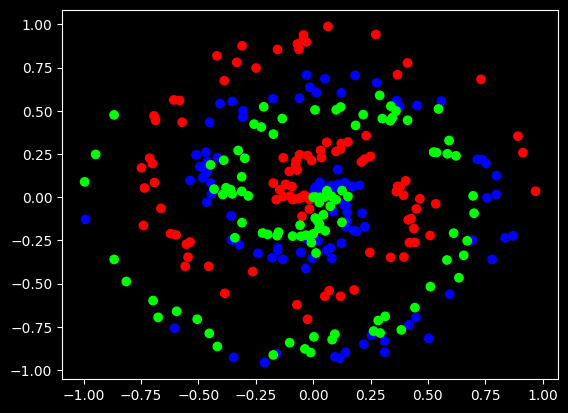

In [37]:
X, y = spiral_data(samples=100, classes=3) #create dataset

#plot dataset
plt.scatter(X[:,0], X[:,1], c=y, cmap='brg') 
plt.show()

### Create Neural Network

In [38]:
#create dense layer with 2 input features and 64 output values
#this layer is 64 neurons
dense1 = Layer_Dense(2, 64)

#create ReLU activation (used in dense layer)
activation1 = ReLU_Activation()

#create second dense layer with 64 input features and 3 output values
#this is the output layer consiting of 3 neurons
#takes output from previous layer
dense2 = Layer_Dense(64, 3)

#create Softmax Classifier's combined loss and activation object 
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy()

#create optimizer object
optimizer = Optimizer_SGD()

### Perform forward Pass

In [39]:
#Perform forward pass of dataset through first dense layer
dense1.forward(X)

#perform forward pass through activation function
#takes output of first dense layer
activation1.forward(dense1.output)

#perform forward pass through 2nd dense layer
#takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)

#perform forward pass through activation/loss function
#takes output of second dense layer and returns loss
loss = loss_activation.forward(dense2.output, y)

#calculate regularization penalty
regularization_loss = loss_activation.loss.regularization_loss(dense1) +\
                        loss_activation.loss.regularization_loss(dense2)

#calculate overall loss
loss = loss + regularization_loss

### Print First Forward Pass Metrics

In [40]:
#print Loss
print(f'Loss: {loss}')

#Print accuracy
Calc_Accuracy(loss_activation.output, y)

Loss: 1.098605751991272
Accuracy: 0.3466666666666667


### Backward Pass: Backpropagation

In [41]:
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

### Optimize weights and biases

In [42]:
optimizer.update_params(dense1)
optimizer.update_params(dense2)

### Do the same forward, backpropagation, and optimization using epochs and same dataset

In [43]:
#X, y = spiral_data(samples=100, classes=3) #create dataset

#create dense layer with 2 input features and 64 output values
#this layer is 64 neurons
dense1 = Layer_Dense(2, 64, weight_lambda_l2=5e-4, bias_lambda_l2=5e-4)

#create ReLU activation (used in dense layer)
activation1 = ReLU_Activation()

#create second dense layer with 64 input features and 3 output values
#this is the output layer consiting of 3 neurons
#takes output from previous layer
dense2 = Layer_Dense(64, 3)

#create Softmax Classifier's combined loss and activation object 
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy()

#create optimizer object
optimizer = Optimizer_SGD(decay=1e-3, momentum=0.5)

for epoch in range(10001):
    #Perform forward pass of dataset through first dense layer
    dense1.forward(X)

    #perform forward pass through activation function
    #takes output of first dense layer
    activation1.forward(dense1.output)

    #perform forward pass through 2nd dense layer
    #takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    #perform forward pass through activation/loss function
    #takes output of second dense layer and returns loss
    data_loss = loss_activation.forward(dense2.output, y)
    
    #calculate regularization penalty
    regularization_loss = loss_activation.loss.regularization_loss(dense1) +\
                        loss_activation.loss.regularization_loss(dense2)

    #calculate overall loss
    loss = data_loss + regularization_loss
    
    #calculate Accuracy
    preds = np.argmax(loss_activation.output, axis=1)
    if(len(y.shape) == 2):
        y = np.argmax(y, axis=1)
    accuracy = np.mean(preds==y)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, '+
        f'acc: {accuracy:.3f}, '+
        f'loss: {loss:.3f} ('+
        f'data_loss: {data_loss:.3f}, '+
        f'reg_loss: {regularization_loss:.3f}), '+
        f'lr: {optimizer.current_learning_rate}')
    
    #backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    #update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, acc: 0.300, loss: 1.099 (data_loss: 1.099, reg_loss: 0.000), lr: 1.0
epoch: 100, acc: 0.410, loss: 1.067 (data_loss: 1.066, reg_loss: 0.001), lr: 0.9099181073703367
epoch: 200, acc: 0.423, loss: 1.063 (data_loss: 1.062, reg_loss: 0.001), lr: 0.8340283569641367
epoch: 300, acc: 0.420, loss: 1.060 (data_loss: 1.059, reg_loss: 0.001), lr: 0.7698229407236336
epoch: 400, acc: 0.423, loss: 1.059 (data_loss: 1.057, reg_loss: 0.001), lr: 0.7147962830593281
epoch: 500, acc: 0.427, loss: 1.056 (data_loss: 1.054, reg_loss: 0.002), lr: 0.66711140760507
epoch: 600, acc: 0.437, loss: 1.050 (data_loss: 1.047, reg_loss: 0.002), lr: 0.6253908692933083
epoch: 700, acc: 0.463, loss: 1.040 (data_loss: 1.036, reg_loss: 0.004), lr: 0.5885815185403178
epoch: 800, acc: 0.467, loss: 1.027 (data_loss: 1.022, reg_loss: 0.006), lr: 0.5558643690939411
epoch: 900, acc: 0.507, loss: 1.015 (data_loss: 1.006, reg_loss: 0.008), lr: 0.526592943654555
epoch: 1000, acc: 0.470, loss: 1.026 (data_loss: 1.015, reg_

epoch: 8500, acc: 0.727, loss: 0.746 (data_loss: 0.662, reg_loss: 0.084), lr: 0.10527423939362038
epoch: 8600, acc: 0.720, loss: 0.743 (data_loss: 0.659, reg_loss: 0.084), lr: 0.10417751849150952
epoch: 8700, acc: 0.743, loss: 0.741 (data_loss: 0.657, reg_loss: 0.084), lr: 0.10310341272296113
epoch: 8800, acc: 0.753, loss: 0.740 (data_loss: 0.655, reg_loss: 0.084), lr: 0.1020512297173181
epoch: 8900, acc: 0.750, loss: 0.738 (data_loss: 0.653, reg_loss: 0.085), lr: 0.10102030508132134
epoch: 9000, acc: 0.757, loss: 0.735 (data_loss: 0.651, reg_loss: 0.085), lr: 0.1000100010001
epoch: 9100, acc: 0.730, loss: 0.731 (data_loss: 0.646, reg_loss: 0.085), lr: 0.09901970492127933
epoch: 9200, acc: 0.730, loss: 0.729 (data_loss: 0.644, reg_loss: 0.085), lr: 0.09804882831650162
epoch: 9300, acc: 0.743, loss: 0.731 (data_loss: 0.646, reg_loss: 0.085), lr: 0.09709680551509856
epoch: 9400, acc: 0.753, loss: 0.730 (data_loss: 0.645, reg_loss: 0.085), lr: 0.09616309260505818
epoch: 9500, acc: 0.753, 

In [44]:
#X, y = spiral_data(samples=100, classes=3) #create dataset

#create dense layer with 2 input features and 64 output values
#this layer is 64 neurons
dense1 = Layer_Dense(2, 64, weight_lambda_l2=5e-4, bias_lambda_l2=5e-4)

#create ReLU activation (used in dense layer)
activation1 = ReLU_Activation()

#create second dense layer with 64 input features and 3 output values
#this is the output layer consiting of 3 neurons
#takes output from previous layer
dense2 = Layer_Dense(64, 3)

#create Softmax Classifier's combined loss and activation object 
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy()

#create optimizer object
optimizer = Optimizer_SGD(decay=1e-3, momentum=0.8)

for epoch in range(10001):
    #Perform forward pass of dataset through first dense layer
    dense1.forward(X)

    #perform forward pass through activation function
    #takes output of first dense layer
    activation1.forward(dense1.output)

    #perform forward pass through 2nd dense layer
    #takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    #perform forward pass through activation/loss function
    #takes output of second dense layer and returns loss
    data_loss = loss_activation.forward(dense2.output, y)
    
    #calculate regularization penalty
    regularization_loss = loss_activation.loss.regularization_loss(dense1) +\
                        loss_activation.loss.regularization_loss(dense2)

    #calculate overall loss
    loss = data_loss + regularization_loss
    
    #calculate Accuracy
    preds = np.argmax(loss_activation.output, axis=1)
    if(len(y.shape) == 2):
        y = np.argmax(y, axis=1)
    accuracy = np.mean(preds==y)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, '+
        f'acc: {accuracy:.3f}, '+
        f'loss: {loss:.3f} ('+
        f'data_loss: {data_loss:.3f}, '+
        f'reg_loss: {regularization_loss:.3f}), '+
        f'lr: {optimizer.current_learning_rate}')
    
    #backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    #update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, acc: 0.327, loss: 1.099 (data_loss: 1.099, reg_loss: 0.000), lr: 1.0
epoch: 100, acc: 0.413, loss: 1.060 (data_loss: 1.059, reg_loss: 0.001), lr: 0.9099181073703367
epoch: 200, acc: 0.453, loss: 1.039 (data_loss: 1.035, reg_loss: 0.004), lr: 0.8340283569641367
epoch: 300, acc: 0.510, loss: 0.987 (data_loss: 0.974, reg_loss: 0.013), lr: 0.7698229407236336
epoch: 400, acc: 0.510, loss: 0.973 (data_loss: 0.950, reg_loss: 0.024), lr: 0.7147962830593281
epoch: 500, acc: 0.527, loss: 0.950 (data_loss: 0.919, reg_loss: 0.031), lr: 0.66711140760507
epoch: 600, acc: 0.483, loss: 0.986 (data_loss: 0.952, reg_loss: 0.034), lr: 0.6253908692933083
epoch: 700, acc: 0.533, loss: 0.955 (data_loss: 0.920, reg_loss: 0.036), lr: 0.5885815185403178
epoch: 800, acc: 0.553, loss: 0.985 (data_loss: 0.948, reg_loss: 0.037), lr: 0.5558643690939411
epoch: 900, acc: 0.570, loss: 0.936 (data_loss: 0.898, reg_loss: 0.038), lr: 0.526592943654555
epoch: 1000, acc: 0.537, loss: 1.062 (data_loss: 1.023, reg_

epoch: 8500, acc: 0.690, loss: 0.770 (data_loss: 0.700, reg_loss: 0.070), lr: 0.10527423939362038
epoch: 8600, acc: 0.700, loss: 0.792 (data_loss: 0.723, reg_loss: 0.070), lr: 0.10417751849150952
epoch: 8700, acc: 0.700, loss: 0.783 (data_loss: 0.713, reg_loss: 0.070), lr: 0.10310341272296113
epoch: 8800, acc: 0.710, loss: 0.772 (data_loss: 0.702, reg_loss: 0.070), lr: 0.1020512297173181
epoch: 8900, acc: 0.710, loss: 0.777 (data_loss: 0.707, reg_loss: 0.070), lr: 0.10102030508132134
epoch: 9000, acc: 0.667, loss: 0.774 (data_loss: 0.704, reg_loss: 0.070), lr: 0.1000100010001
epoch: 9100, acc: 0.717, loss: 0.775 (data_loss: 0.704, reg_loss: 0.070), lr: 0.09901970492127933
epoch: 9200, acc: 0.693, loss: 0.770 (data_loss: 0.700, reg_loss: 0.071), lr: 0.09804882831650162
epoch: 9300, acc: 0.713, loss: 0.788 (data_loss: 0.717, reg_loss: 0.071), lr: 0.09709680551509856
epoch: 9400, acc: 0.670, loss: 0.781 (data_loss: 0.710, reg_loss: 0.071), lr: 0.09616309260505818
epoch: 9500, acc: 0.707, 

## SGD with Adaptive Gradient (AdaGrad) Optimizer

In [45]:
class Optimizer_Adagrad:
    
    #initialize optimizer - set hyper parameters
    def __init__(self, learning_rate=1.0, decay=0, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        
    #Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
            (1.0 / (1.0 + self.decay * self.iterations))
        
    #update parameters
    def update_params(self, layer):
        
        #if layer does not contain cache arrays
        #create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            #if there is no cache array for weights
            #the array doesn't exist for biases either
            layer.bias_cache = np.zeros_like(layer.biases)
            
        #update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2
        
        #Vanilla SGD parameter update + normalization
        #with square rooted cache
        layer.weights += -self.current_learning_rate * \
            layer.dweights / \
            (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
            layer.dbiases / \
            (np.sqrt(layer.bias_cache) + self.epsilon)
        
    #call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

## Create 1x64 dense Neural Net using same dataset using AdaGrad Optimizer

In [46]:
#X, y = spiral_data(samples=100, classes=3) #create dataset

#create dense layer with 2 input features and 64 output values
#this layer is 64 neurons
dense1 = Layer_Dense(2, 64, weight_lambda_l2=5e-4, bias_lambda_l2=5e-4)

#create ReLU activation (used in dense layer)
activation1 = ReLU_Activation()

#create second dense layer with 64 input features and 3 output values
#this is the output layer consiting of 3 neurons
#takes output from previous layer
dense2 = Layer_Dense(64, 3)

#create Softmax Classifier's combined loss and activation object 
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy()

#create optimizer object
optimizer = Optimizer_Adagrad(decay=1e-3)

for epoch in range(10001):
    #Perform forward pass of dataset through first dense layer
    dense1.forward(X)

    #perform forward pass through activation function
    #takes output of first dense layer
    activation1.forward(dense1.output)

    #perform forward pass through 2nd dense layer
    #takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    #perform forward pass through activation/loss function
    #takes output of second dense layer and returns loss
    data_loss = loss_activation.forward(dense2.output, y)
    
    #calculate regularization penalty
    regularization_loss = loss_activation.loss.regularization_loss(dense1) +\
                        loss_activation.loss.regularization_loss(dense2)

    #calculate overall loss
    loss = data_loss + regularization_loss
    
    #calculate Accuracy
    preds = np.argmax(loss_activation.output, axis=1)
    if(len(y.shape) == 2):
        y = np.argmax(y, axis=1)
    accuracy = np.mean(preds==y)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, '+
        f'acc: {accuracy:.3f}, '+
        f'loss: {loss:.3f} ('+
        f'data_loss: {data_loss:.3f}, '+
        f'reg_loss: {regularization_loss:.3f}), '+
        f'lr: {optimizer.current_learning_rate}')
    
    #backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    #update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, acc: 0.370, loss: 1.099 (data_loss: 1.099, reg_loss: 0.000), lr: 1.0
epoch: 100, acc: 0.390, loss: 1.141 (data_loss: 1.117, reg_loss: 0.025), lr: 0.9099181073703367
epoch: 200, acc: 0.507, loss: 0.993 (data_loss: 0.967, reg_loss: 0.025), lr: 0.8340283569641367
epoch: 300, acc: 0.560, loss: 0.966 (data_loss: 0.937, reg_loss: 0.029), lr: 0.7698229407236336
epoch: 400, acc: 0.567, loss: 0.944 (data_loss: 0.912, reg_loss: 0.032), lr: 0.7147962830593281
epoch: 500, acc: 0.547, loss: 0.927 (data_loss: 0.891, reg_loss: 0.036), lr: 0.66711140760507
epoch: 600, acc: 0.593, loss: 0.905 (data_loss: 0.866, reg_loss: 0.039), lr: 0.6253908692933083
epoch: 700, acc: 0.593, loss: 0.892 (data_loss: 0.850, reg_loss: 0.041), lr: 0.5885815185403178
epoch: 800, acc: 0.593, loss: 0.879 (data_loss: 0.836, reg_loss: 0.043), lr: 0.5558643690939411
epoch: 900, acc: 0.597, loss: 0.870 (data_loss: 0.826, reg_loss: 0.044), lr: 0.526592943654555
epoch: 1000, acc: 0.597, loss: 0.861 (data_loss: 0.816, reg_

epoch: 8500, acc: 0.730, loss: 0.702 (data_loss: 0.632, reg_loss: 0.070), lr: 0.10527423939362038
epoch: 8600, acc: 0.737, loss: 0.701 (data_loss: 0.630, reg_loss: 0.070), lr: 0.10417751849150952
epoch: 8700, acc: 0.743, loss: 0.700 (data_loss: 0.629, reg_loss: 0.070), lr: 0.10310341272296113
epoch: 8800, acc: 0.743, loss: 0.699 (data_loss: 0.628, reg_loss: 0.071), lr: 0.1020512297173181
epoch: 8900, acc: 0.747, loss: 0.698 (data_loss: 0.627, reg_loss: 0.071), lr: 0.10102030508132134
epoch: 9000, acc: 0.747, loss: 0.696 (data_loss: 0.625, reg_loss: 0.071), lr: 0.1000100010001
epoch: 9100, acc: 0.747, loss: 0.695 (data_loss: 0.624, reg_loss: 0.071), lr: 0.09901970492127933
epoch: 9200, acc: 0.747, loss: 0.694 (data_loss: 0.623, reg_loss: 0.071), lr: 0.09804882831650162
epoch: 9300, acc: 0.747, loss: 0.693 (data_loss: 0.622, reg_loss: 0.071), lr: 0.09709680551509856
epoch: 9400, acc: 0.747, loss: 0.693 (data_loss: 0.621, reg_loss: 0.072), lr: 0.09616309260505818
epoch: 9500, acc: 0.750, 

## SGD with Root Mean Square Propagation (RMSProp) Optimization

In [47]:
class Optimizer_RMSProp:
    
    #initialize optimizer - set hyper parameters
    def __init__(self, learning_rate=0.001, decay=0, epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
        
    #Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
            (1.0 / (1.0 + self.decay * self.iterations))
        
    #update parameters
    def update_params(self, layer):
        
        #if layer does not contain cache arrays
        #create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            #if there is no cache array for weights
            #the array doesn't exist for biases either
            layer.bias_cache = np.zeros_like(layer.biases)
            
        #update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + \
            (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + \
            (1 - self.rho) * layer.dbiases**2
        
        #Vanilla SGD parameter update + normalization
        #with square rooted cache
        layer.weights += -self.current_learning_rate * \
            layer.dweights / \
            (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
            layer.dbiases / \
            (np.sqrt(layer.bias_cache) + self.epsilon)
        
    #call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

## Create 1x64 dense Neural Net using same dataset using RMSProp Optimizer

In [48]:
#X, y = spiral_data(samples=100, classes=3) #create dataset

#create dense layer with 2 input features and 64 output values
#this layer is 64 neurons
dense1 = Layer_Dense(2, 64, weight_lambda_l2=5e-4, bias_lambda_l2=5e-4)

#create ReLU activation (used in dense layer)
activation1 = ReLU_Activation()

#create second dense layer with 64 input features and 3 output values
#this is the output layer consiting of 3 neurons
#takes output from previous layer
dense2 = Layer_Dense(64, 3)

#create Softmax Classifier's combined loss and activation object 
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy()

#create optimizer object
optimizer = Optimizer_RMSProp(decay=1e-4)

for epoch in range(10001):
    #Perform forward pass of dataset through first dense layer
    dense1.forward(X)

    #perform forward pass through activation function
    #takes output of first dense layer
    activation1.forward(dense1.output)

    #perform forward pass through 2nd dense layer
    #takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    #perform forward pass through activation/loss function
    #takes output of second dense layer and returns loss
    data_loss = loss_activation.forward(dense2.output, y)
    
    #calculate regularization penalty
    regularization_loss = loss_activation.loss.regularization_loss(dense1) +\
                        loss_activation.loss.regularization_loss(dense2)

    #calculate overall loss
    loss = data_loss + regularization_loss
    
    #calculate Accuracy
    preds = np.argmax(loss_activation.output, axis=1)
    if(len(y.shape) == 2):
        y = np.argmax(y, axis=1)
    accuracy = np.mean(preds==y)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, '+
        f'acc: {accuracy:.3f}, '+
        f'loss: {loss:.3f} ('+
        f'data_loss: {data_loss:.3f}, '+
        f'reg_loss: {regularization_loss:.3f}), '+
        f'lr: {optimizer.current_learning_rate}')
    
    #backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    #update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, acc: 0.377, loss: 1.099 (data_loss: 1.099, reg_loss: 0.000), lr: 0.001
epoch: 100, acc: 0.407, loss: 1.067 (data_loss: 1.066, reg_loss: 0.001), lr: 0.0009901970492127933
epoch: 200, acc: 0.423, loss: 1.060 (data_loss: 1.059, reg_loss: 0.001), lr: 0.0009804882831650162
epoch: 300, acc: 0.423, loss: 1.054 (data_loss: 1.052, reg_loss: 0.002), lr: 0.0009709680551509856
epoch: 400, acc: 0.437, loss: 1.045 (data_loss: 1.042, reg_loss: 0.003), lr: 0.0009616309260505818
epoch: 500, acc: 0.457, loss: 1.031 (data_loss: 1.026, reg_loss: 0.005), lr: 0.0009524716639679969
epoch: 600, acc: 0.503, loss: 1.015 (data_loss: 1.008, reg_loss: 0.007), lr: 0.0009434852344560807
epoch: 700, acc: 0.540, loss: 0.999 (data_loss: 0.989, reg_loss: 0.010), lr: 0.0009346667912889054
epoch: 800, acc: 0.523, loss: 0.985 (data_loss: 0.972, reg_loss: 0.013), lr: 0.0009260116677470135
epoch: 900, acc: 0.537, loss: 0.973 (data_loss: 0.958, reg_loss: 0.015), lr: 0.0009175153683824203
epoch: 1000, acc: 0.543, los

epoch: 8300, acc: 0.710, loss: 0.759 (data_loss: 0.701, reg_loss: 0.059), lr: 0.0005464779496147331
epoch: 8400, acc: 0.713, loss: 0.758 (data_loss: 0.699, reg_loss: 0.059), lr: 0.0005435077993369205
epoch: 8500, acc: 0.713, loss: 0.757 (data_loss: 0.698, reg_loss: 0.059), lr: 0.000540569760527596
epoch: 8600, acc: 0.710, loss: 0.756 (data_loss: 0.697, reg_loss: 0.059), lr: 0.0005376633152320017
epoch: 8700, acc: 0.723, loss: 0.755 (data_loss: 0.696, reg_loss: 0.059), lr: 0.0005347879565752179
epoch: 8800, acc: 0.720, loss: 0.754 (data_loss: 0.695, reg_loss: 0.060), lr: 0.0005319431884674717
epoch: 8900, acc: 0.710, loss: 0.753 (data_loss: 0.694, reg_loss: 0.060), lr: 0.0005291285253188
epoch: 9000, acc: 0.713, loss: 0.752 (data_loss: 0.693, reg_loss: 0.060), lr: 0.0005263434917627244
epoch: 9100, acc: 0.707, loss: 0.750 (data_loss: 0.690, reg_loss: 0.060), lr: 0.0005235876223886069
epoch: 9200, acc: 0.723, loss: 0.748 (data_loss: 0.688, reg_loss: 0.060), lr: 0.0005208604614823689
epoc

## SGD with Adaptive Momentum (Adam) Optimization

In [49]:
class Optimizer_Adam:
    
    #initialize optimizer - set hyper parameters
    def __init__(self, learning_rate=0.001, decay=0, epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
    #Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
            (1.0 / (1.0 + self.decay * self.iterations))
        
    #update parameters
    def update_params(self, layer):
        
        #if layer does not contain bias and weight cache arrays
        #create them filled with zeros
        #initialize bias and weight momentum arrays
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
            
            
        #update momentum with current gradients
        layer.weight_momentums = self.beta_1 * \
            layer.weight_momentums + \
            (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
            layer.bias_momentums + \
            (1 - self.beta_1) * layer.dbiases
        
        #Get corrected momentum
        #self.iteration is 0 at first pass
        #we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
            (1 - self.beta_1** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
            (1 - self.beta_1** (self.iterations + 1))
            
            
        #update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
            (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
            (1 - self.beta_2) * layer.dbiases**2
        
        #Get corrected Cache
        #self.iteration is 0 at first pass
        #we need to start with 1 here
        weight_cache_corrected = layer.weight_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        
        
        #Vanilla SGD parameter update + normalization
        #with square rooted cache
        layer.weights += -self.current_learning_rate * \
             weight_momentums_corrected / \
            (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
            bias_momentums_corrected / \
            (np.sqrt(bias_cache_corrected) + self.epsilon)
        
    #call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

## Create 1x64 dense Neural Net using same dataset using Adam Optimizer

In [50]:
#X, y = spiral_data(samples=100, classes=3) #create dataset

#create dense layer with 2 input features and 64 output values
#this layer is 64 neurons
dense1 = Layer_Dense(2, 64, weight_lambda_l2=5e-4, bias_lambda_l2=5e-4)

#create ReLU activation (used in dense layer)
activation1 = ReLU_Activation()

#create second dense layer with 64 input features and 3 output values
#this is the output layer consiting of 3 neurons
#takes output from previous layer
dense2 = Layer_Dense(64, 3)

#create Softmax Classifier's combined loss and activation object 
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy()

#create optimizer object
optimizer = Optimizer_Adam(learning_rate=0.01, decay=1e-7)

for epoch in range(10001):
    #Perform forward pass of dataset through first dense layer
    dense1.forward(X)

    #perform forward pass through activation function
    #takes output of first dense layer
    activation1.forward(dense1.output)

    #perform forward pass through 2nd dense layer
    #takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    #perform forward pass through activation/loss function
    #takes output of second dense layer and returns loss
    data_loss = loss_activation.forward(dense2.output, y)
    
    #calculate regularization penalty
    regularization_loss = loss_activation.loss.regularization_loss(dense1) +\
                        loss_activation.loss.regularization_loss(dense2)

    #calculate overall loss
    loss = data_loss + regularization_loss
    
    #calculate Accuracy
    preds = np.argmax(loss_activation.output, axis=1)
    if(len(y.shape) == 2):
        y = np.argmax(y, axis=1)
    accuracy = np.mean(preds==y)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, '+
        f'acc: {accuracy:.3f}, '+
        f'loss: {loss:.3f} ('+
        f'data_loss: {data_loss:.3f}, '+
        f'reg_loss: {regularization_loss:.3f}), '+
        f'lr: {optimizer.current_learning_rate}')
    
    #backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    #update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, acc: 0.333, loss: 1.099 (data_loss: 1.099, reg_loss: 0.000), lr: 0.01
epoch: 100, acc: 0.543, loss: 0.964 (data_loss: 0.951, reg_loss: 0.013), lr: 0.009999901000980091
epoch: 200, acc: 0.690, loss: 0.805 (data_loss: 0.759, reg_loss: 0.046), lr: 0.00999980100396002
epoch: 300, acc: 0.730, loss: 0.720 (data_loss: 0.653, reg_loss: 0.067), lr: 0.009999701008939833
epoch: 400, acc: 0.757, loss: 0.666 (data_loss: 0.587, reg_loss: 0.078), lr: 0.009999601015919466
epoch: 500, acc: 0.783, loss: 0.629 (data_loss: 0.544, reg_loss: 0.086), lr: 0.009999501024898856
epoch: 600, acc: 0.800, loss: 0.604 (data_loss: 0.514, reg_loss: 0.090), lr: 0.009999401035877951
epoch: 700, acc: 0.800, loss: 0.584 (data_loss: 0.493, reg_loss: 0.091), lr: 0.009999301048856686
epoch: 800, acc: 0.807, loss: 0.566 (data_loss: 0.474, reg_loss: 0.092), lr: 0.009999201063834999
epoch: 900, acc: 0.807, loss: 0.550 (data_loss: 0.459, reg_loss: 0.092), lr: 0.009999101080812835
epoch: 1000, acc: 0.813, loss: 0.532 (d

epoch: 8400, acc: 0.917, loss: 0.295 (data_loss: 0.233, reg_loss: 0.063), lr: 0.009991608048400151
epoch: 8500, acc: 0.920, loss: 0.294 (data_loss: 0.232, reg_loss: 0.062), lr: 0.00999150821716623
epoch: 8600, acc: 0.927, loss: 0.293 (data_loss: 0.231, reg_loss: 0.062), lr: 0.009991408387927222
epoch: 8700, acc: 0.923, loss: 0.292 (data_loss: 0.230, reg_loss: 0.062), lr: 0.009991308560683062
epoch: 8800, acc: 0.920, loss: 0.291 (data_loss: 0.230, reg_loss: 0.062), lr: 0.009991208735433693
epoch: 8900, acc: 0.920, loss: 0.290 (data_loss: 0.228, reg_loss: 0.061), lr: 0.009991108912179051
epoch: 9000, acc: 0.920, loss: 0.289 (data_loss: 0.228, reg_loss: 0.061), lr: 0.009991009090919082
epoch: 9100, acc: 0.923, loss: 0.288 (data_loss: 0.227, reg_loss: 0.061), lr: 0.009990909271653723
epoch: 9200, acc: 0.923, loss: 0.287 (data_loss: 0.226, reg_loss: 0.061), lr: 0.009990809454382913
epoch: 9300, acc: 0.923, loss: 0.286 (data_loss: 0.226, reg_loss: 0.060), lr: 0.009990709639106594
epoch: 9400

## Validation of Adam Optimzer

In [51]:
#create test data
X_test, y_test = spiral_data(samples=100, classes=3)

#perform forward pass of testing data through this layer
dense1.forward(X_test)

#perform forward pass through activation function
#takes output of first dense layer
activation1.forward(dense1.output)

#perform forward pass through 2nd dense layer
#takes output of activation function of 1st layer as inputs
dense2.forward(activation1.output)

#perform forward pass through the activation/loss function
#takes the output of the 2nd dense layer and returns loss
data_loss = loss_activation.forward(dense2.output, y_test)

#calculate regularization penalty
regularization_loss = loss_activation.loss.regularization_loss(dense1) +\
                        loss_activation.loss.regularization_loss(dense2)

#calculate overall loss
loss = data_loss + regularization_loss

#calculate accuract from output of activation2 and targets
preds = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(preds==y_test)

print(f'Validation, acc: {accuracy:.3f}, loss: {loss:.3f}\
        (data_loss: {data_loss:.3f}, reg_loss: {regularization_loss:.3f})')

Validation, acc: 0.827, loss: 0.609        (data_loss: 0.550, reg_loss: 0.059)


## Create 1x256 dense Neural Net using same dataset and more samples using Adam Optimizer

In [52]:
X, y = spiral_data(samples=1000, classes=3) #create dataset

#create dense layer with 2 input features and 64 output values
#this layer is 64 neurons
dense1 = Layer_Dense(2, 64, weight_lambda_l2=5e-4, bias_lambda_l2=5e-4)

#create ReLU activation (used in dense layer)
activation1 = ReLU_Activation()

#create second dense layer with 64 input features and 3 output values
#this is the output layer consiting of 3 neurons
#takes output from previous layer
dense2 = Layer_Dense(64, 3)

#create Softmax Classifier's combined loss and activation object 
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy()

#create optimizer object
optimizer = Optimizer_Adam(learning_rate=0.01, decay=1e-7)

for epoch in range(10001):
    #Perform forward pass of dataset through first dense layer
    dense1.forward(X)

    #perform forward pass through activation function
    #takes output of first dense layer
    activation1.forward(dense1.output)

    #perform forward pass through 2nd dense layer
    #takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    #perform forward pass through activation/loss function
    #takes output of second dense layer and returns loss
    data_loss = loss_activation.forward(dense2.output, y)
    
    #calculate regularization penalty
    regularization_loss = loss_activation.loss.regularization_loss(dense1) +\
                        loss_activation.loss.regularization_loss(dense2)

    #calculate overall loss
    loss = data_loss + regularization_loss
    
    #calculate Accuracy
    preds = np.argmax(loss_activation.output, axis=1)
    if(len(y.shape) == 2):
        y = np.argmax(y, axis=1)
    accuracy = np.mean(preds==y)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, '+
        f'acc: {accuracy:.3f}, '+
        f'loss: {loss:.3f} ('+
        f'data_loss: {data_loss:.3f}, '+
        f'reg_loss: {regularization_loss:.3f}), '+
        f'lr: {optimizer.current_learning_rate}')
    
    #backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    #update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, acc: 0.368, loss: 1.099 (data_loss: 1.099, reg_loss: 0.000), lr: 0.01
epoch: 100, acc: 0.454, loss: 1.008 (data_loss: 0.996, reg_loss: 0.011), lr: 0.009999901000980091
epoch: 200, acc: 0.630, loss: 0.882 (data_loss: 0.841, reg_loss: 0.041), lr: 0.00999980100396002
epoch: 300, acc: 0.695, loss: 0.805 (data_loss: 0.742, reg_loss: 0.062), lr: 0.009999701008939833
epoch: 400, acc: 0.756, loss: 0.758 (data_loss: 0.682, reg_loss: 0.076), lr: 0.009999601015919466
epoch: 500, acc: 0.771, loss: 0.723 (data_loss: 0.639, reg_loss: 0.084), lr: 0.009999501024898856
epoch: 600, acc: 0.785, loss: 0.699 (data_loss: 0.609, reg_loss: 0.089), lr: 0.009999401035877951
epoch: 700, acc: 0.799, loss: 0.672 (data_loss: 0.579, reg_loss: 0.093), lr: 0.009999301048856686
epoch: 800, acc: 0.808, loss: 0.645 (data_loss: 0.549, reg_loss: 0.096), lr: 0.009999201063834999
epoch: 900, acc: 0.820, loss: 0.622 (data_loss: 0.523, reg_loss: 0.099), lr: 0.009999101080812835
epoch: 1000, acc: 0.831, loss: 0.605 (d

epoch: 8400, acc: 0.894, loss: 0.367 (data_loss: 0.296, reg_loss: 0.071), lr: 0.009991608048400151
epoch: 8500, acc: 0.891, loss: 0.366 (data_loss: 0.295, reg_loss: 0.071), lr: 0.00999150821716623
epoch: 8600, acc: 0.894, loss: 0.367 (data_loss: 0.297, reg_loss: 0.070), lr: 0.009991408387927222
epoch: 8700, acc: 0.893, loss: 0.364 (data_loss: 0.295, reg_loss: 0.070), lr: 0.009991308560683062
epoch: 8800, acc: 0.895, loss: 0.365 (data_loss: 0.295, reg_loss: 0.070), lr: 0.009991208735433693
epoch: 8900, acc: 0.893, loss: 0.362 (data_loss: 0.293, reg_loss: 0.069), lr: 0.009991108912179051
epoch: 9000, acc: 0.895, loss: 0.362 (data_loss: 0.293, reg_loss: 0.069), lr: 0.009991009090919082
epoch: 9100, acc: 0.895, loss: 0.361 (data_loss: 0.292, reg_loss: 0.069), lr: 0.009990909271653723
epoch: 9200, acc: 0.893, loss: 0.360 (data_loss: 0.292, reg_loss: 0.069), lr: 0.009990809454382913
epoch: 9300, acc: 0.895, loss: 0.359 (data_loss: 0.291, reg_loss: 0.068), lr: 0.009990709639106594
epoch: 9400

In [53]:
#create test data
X_test, y_test = spiral_data(samples=100, classes=3)

#perform forward pass of testing data through this layer
dense1.forward(X_test)

#perform forward pass through activation function
#takes output of first dense layer
activation1.forward(dense1.output)

#perform forward pass through 2nd dense layer
#takes output of activation function of 1st layer as inputs
dense2.forward(activation1.output)

#perform forward pass through the activation/loss function
#takes the output of the 2nd dense layer and returns loss
data_loss = loss_activation.forward(dense2.output, y_test)

#calculate regularization penalty
regularization_loss = loss_activation.loss.regularization_loss(dense1) +\
                        loss_activation.loss.regularization_loss(dense2)

#calculate overall loss
loss = data_loss + regularization_loss

#calculate accuract from output of activation2 and targets
preds = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(preds==y_test)

print(f'Validation, acc: {accuracy:.3f}, loss: {loss:.3f}\
        (data_loss: {data_loss:.3f}, reg_loss: {regularization_loss:.3f})')

Validation, acc: 0.823, loss: 0.477        (data_loss: 0.411, reg_loss: 0.066)


## Dropout layer Class
This class implements a dropout layer into the neural network

In [54]:
class Layer_Dropout:
    #init
    def __init__(self, rate):
        #store rate, we invert it as for dropout of 0.1 we need a success rate of 0.9
        self.rate = 1 - rate
    
    #forward pass through dropout layer
    def forward(self, inputs):
        #save input values
        self.inputs = inputs
        
        #generate and save scaled mask
        self.binary_mask = np.random.binomial(1, self.rate,\
                            size=inputs.shape) / self.rate
        
        #apply mask to output values
        self.output = inputs * self.binary_mask
        
    #backward pass
    def backward(self, dvalues):
        #gradient on values
        #This partial derivative ends up being the same as binary_mask
        #ri / (1 - q)
        self.dinputs = dvalues * self.binary_mask

## Create 1x256 dense Neural Net using Adam Optimizer and Dropout Layer

In [55]:
X, y = spiral_data(samples=1000, classes=3) #create dataset

#create dense layer with 2 input features and 64 output values
#this layer is 64 neurons
dense1 = Layer_Dense(2, 64, weight_lambda_l2=5e-4, bias_lambda_l2=5e-4)

#create ReLU activation (used in dense layer)
activation1 = ReLU_Activation()

#create Dropout Layer
dropout1 = Layer_Dropout(0.1)

#create second dense layer with 64 input features and 3 output values
#this is the output layer consiting of 3 neurons
#takes output from previous layer
dense2 = Layer_Dense(64, 3)

#create Softmax Classifier's combined loss and activation object 
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy()

#create optimizer object
optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-5)

for epoch in range(10001):
    #Perform forward pass of dataset through first dense layer
    dense1.forward(X)

    #perform forward pass through activation function
    #takes output of first dense layer
    activation1.forward(dense1.output)
    
    #perform forward pass through Dropout Layer
    dropout1.forward(activation1.output)

    #perform forward pass through 2nd dense layer
    #takes outputs of activation function of first layer as inputs
    dense2.forward(dropout1.output)

    #perform forward pass through activation/loss function
    #takes output of second dense layer and returns loss
    data_loss = loss_activation.forward(dense2.output, y)
    
    #calculate regularization penalty
    regularization_loss = loss_activation.loss.regularization_loss(dense1) +\
                        loss_activation.loss.regularization_loss(dense2)

    #calculate overall loss
    loss = data_loss + regularization_loss
    
    #calculate Accuracy
    preds = np.argmax(loss_activation.output, axis=1)
    if(len(y.shape) == 2):
        y = np.argmax(y, axis=1)
    accuracy = np.mean(preds==y)
    
    if not epoch % 100:
        print(f'epoch: {epoch}, '+
        f'acc: {accuracy:.3f}, '+
        f'loss: {loss:.3f} ('+
        f'data_loss: {data_loss:.3f}, '+
        f'reg_loss: {regularization_loss:.3f}), '+
        f'lr: {optimizer.current_learning_rate}')
    
    #backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    dropout1.backward(dense2.dinputs)
    activation1.backward(dropout1.dinputs)
    dense1.backward(activation1.dinputs)
    
    #update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, acc: 0.338, loss: 1.099 (data_loss: 1.099, reg_loss: 0.000), lr: 0.05
epoch: 100, acc: 0.532, loss: 0.921 (data_loss: 0.897, reg_loss: 0.024), lr: 0.04975371909050202
epoch: 200, acc: 0.612, loss: 0.864 (data_loss: 0.833, reg_loss: 0.031), lr: 0.049507401356502806
epoch: 300, acc: 0.626, loss: 0.840 (data_loss: 0.810, reg_loss: 0.030), lr: 0.0492635105177595
epoch: 400, acc: 0.645, loss: 0.837 (data_loss: 0.808, reg_loss: 0.029), lr: 0.04902201088288642
epoch: 500, acc: 0.624, loss: 0.841 (data_loss: 0.813, reg_loss: 0.028), lr: 0.048782867456949125
epoch: 600, acc: 0.625, loss: 0.814 (data_loss: 0.787, reg_loss: 0.027), lr: 0.04854604592455945
epoch: 700, acc: 0.633, loss: 0.826 (data_loss: 0.800, reg_loss: 0.026), lr: 0.048311512633460556
epoch: 800, acc: 0.643, loss: 0.793 (data_loss: 0.768, reg_loss: 0.025), lr: 0.04807923457858551
epoch: 900, acc: 0.636, loss: 0.811 (data_loss: 0.787, reg_loss: 0.024), lr: 0.04784917938657352
epoch: 1000, acc: 0.630, loss: 0.824 (data_lo

epoch: 8400, acc: 0.647, loss: 0.774 (data_loss: 0.761, reg_loss: 0.013), lr: 0.03521250748265784
epoch: 8500, acc: 0.644, loss: 0.778 (data_loss: 0.765, reg_loss: 0.012), lr: 0.035088950489490865
epoch: 8600, acc: 0.646, loss: 0.766 (data_loss: 0.754, reg_loss: 0.012), lr: 0.0349662575614532
epoch: 8700, acc: 0.652, loss: 0.765 (data_loss: 0.753, reg_loss: 0.012), lr: 0.034844419666190465
epoch: 8800, acc: 0.644, loss: 0.763 (data_loss: 0.751, reg_loss: 0.012), lr: 0.034723427896801974
epoch: 8900, acc: 0.644, loss: 0.773 (data_loss: 0.760, reg_loss: 0.012), lr: 0.03460327346967023
epoch: 9000, acc: 0.651, loss: 0.770 (data_loss: 0.758, reg_loss: 0.012), lr: 0.034483947722335255
epoch: 9100, acc: 0.639, loss: 0.782 (data_loss: 0.770, reg_loss: 0.012), lr: 0.034365442111412764
epoch: 9200, acc: 0.656, loss: 0.775 (data_loss: 0.763, reg_loss: 0.012), lr: 0.03424774821055516
epoch: 9300, acc: 0.647, loss: 0.786 (data_loss: 0.773, reg_loss: 0.012), lr: 0.03413085770845422
epoch: 9400, acc

## Sigmoid Activation class
This is used for binary logistic regression or Binary classification in the output layer

In [56]:
class Activation_Sigmoid:
        #forward pass
        def forward(self, inputs):
            #save input and calculate/save output
            self.inputs = inputs
            self.output = 1 / (1 + np.exp(-inputs))
            
        #backward pass
        def backward(self, dvalues):
            #derivative calculates from output of sigmoid function
            #sigmoid * (1 - sigmoid)
            self.dinputs = dvalues * (1 - self.output) * self.output

## Binary Cross-Entropy Loss
This is used with a binary classifier such as the sigmoid function

In [57]:
class Loss_BinaryCrossEntropy(Loss):
    #forward pass
    def forward(self, y_pred, y_true):
        
        #clip data to prevent division by 0
        #clip both sides to bring mean to any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        #calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) +\
                         (1 - y_true) * np.log(1 - y_pred_clipped))
        #calculate mean of each sample
        #do this by going along each sample (axis=-1)
        sample_losses = np.mean(sample_losses, axis=-1)
        
        #return losses
        return sample_losses
    
    #backward pass
    def backward(self, dvalues, y_true):
        
        #number of samples
        num_samples = len(dvalues)
        
        #number of outputs in every sample (1 per neuron)
        #use 1st sample to count them
        num_outputs = len(dvalues[0])
        
        #clip data to prevent division by 0
        #clip both sides to bring mean to any value
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)
        
        #calculate gradient
        self.dinputs = -(y_true / clipped_dvalues -\
                        (1 - y_true) / (1 - clipped_dvalues)) / num_outputs
        
        #normalize gradient
        self.dinputs = self.dinputs / num_samples

## Binary Logistic Regression using Sigmoid and Binary Cross-Entropy Loss

In [58]:
#create dataset
X, y = spiral_data(samples=100, classes=2)

#reshape labels to be list of lists
#inner list contains 1 output (0 or 1) per each output neuron
#which will be 1 output neuron in this example
y = y.reshape(-1, 1)

#create dense layer with 2 input features and 64 output values (64 neurons)
dense1 = Layer_Dense(2, 64, weight_lambda_l2=5e-4, bias_lambda_l2=5e-4)

#create ReLU activation (to be used in dense layer)
activation1 = ReLU_Activation()

#create 2nd dense layer with 64 input features
#take output from the previous layer
#and 1 output value (1 output neuron)
dense2 = Layer_Dense(64, 1)

#create Sigmoid activation
activation2 = Activation_Sigmoid()

#create loss function
loss_function = Loss_BinaryCrossEntropy()

#create optimizer
optimizer = Optimizer_Adam(decay=5e-7)

for epoch in range(10001):
    #perform forward pass of training data through this layer
    dense1.forward(X)
    
    #perform forward pass through activation function
    #takes output of first dense layer
    activation1.forward(dense1.output)
    
    #perform forward pass through 2nd dense layer
    #takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    
    #perform forward pass through activation function
    #takes the output of 2nd dense layer
    activation2.forward(dense2.output)

    #perform forward pass through activation/loss function
    #takes output of second dense layer and returns data loss
    #this inherently calles the forward function in the binaryCrossEntropy class
    data_loss = loss_function.calculate(activation2.output, y)
    
    #calculate regularization penalty
    regularization_loss = loss_function.regularization_loss(dense1) +\
                        loss_function.regularization_loss(dense2)

    #calculate overall loss
    loss = data_loss + regularization_loss
    
    #calculate Accuracy from output of activation2 and targets
    #part in parenthesis returns a binary mask - array consisting of True/False values
    #multiplying by 1 changes it into an array of 1s and 0s
    preds = (activation2.output > 0.5) * 1
    accuracy = np.mean(preds==y)
    
    
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
        f'acc: {accuracy:.3f}, ' +
        f'loss: {loss:.3f} (' +
        f'data_loss: {data_loss:.3f}, ' +
        f'reg_loss: {regularization_loss:.6f}), ' +
        f'lr: {optimizer.current_learning_rate}')
    
    #backward pass
    loss_function.backward(activation2.output, y)
    activation2.backward(loss_function.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    #update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, acc: 0.490, loss: 0.693 (data_loss: 0.693, reg_loss: 0.000007), lr: 0.001
epoch: 100, acc: 0.580, loss: 0.678 (data_loss: 0.678, reg_loss: 0.000694), lr: 0.0009999505024501287
epoch: 200, acc: 0.590, loss: 0.671 (data_loss: 0.669, reg_loss: 0.001483), lr: 0.0009999005098992651
epoch: 300, acc: 0.580, loss: 0.666 (data_loss: 0.664, reg_loss: 0.002100), lr: 0.000999850522346909
epoch: 400, acc: 0.595, loss: 0.658 (data_loss: 0.655, reg_loss: 0.003221), lr: 0.0009998005397923115
epoch: 500, acc: 0.610, loss: 0.650 (data_loss: 0.645, reg_loss: 0.004897), lr: 0.0009997505622347225
epoch: 600, acc: 0.650, loss: 0.639 (data_loss: 0.632, reg_loss: 0.007058), lr: 0.0009997005896733929
epoch: 700, acc: 0.635, loss: 0.628 (data_loss: 0.618, reg_loss: 0.009457), lr: 0.0009996506221075735
epoch: 800, acc: 0.680, loss: 0.617 (data_loss: 0.605, reg_loss: 0.011930), lr: 0.000999600659536515
epoch: 900, acc: 0.680, loss: 0.605 (data_loss: 0.591, reg_loss: 0.014524), lr: 0.0009995507019594694


epoch: 8200, acc: 0.910, loss: 0.304 (data_loss: 0.244, reg_loss: 0.059338), lr: 0.000995917237285747
epoch: 8300, acc: 0.910, loss: 0.302 (data_loss: 0.243, reg_loss: 0.059183), lr: 0.000995867647197952
epoch: 8400, acc: 0.910, loss: 0.301 (data_loss: 0.242, reg_loss: 0.059027), lr: 0.0009958180620484277
epoch: 8500, acc: 0.910, loss: 0.300 (data_loss: 0.241, reg_loss: 0.058876), lr: 0.0009957684818364362
epoch: 8600, acc: 0.910, loss: 0.299 (data_loss: 0.240, reg_loss: 0.058716), lr: 0.0009957189065612402
epoch: 8700, acc: 0.910, loss: 0.297 (data_loss: 0.239, reg_loss: 0.058561), lr: 0.000995669336222102
epoch: 8800, acc: 0.910, loss: 0.296 (data_loss: 0.238, reg_loss: 0.058404), lr: 0.000995619770818285
epoch: 8900, acc: 0.910, loss: 0.295 (data_loss: 0.237, reg_loss: 0.058246), lr: 0.0009955702103490519
epoch: 9000, acc: 0.910, loss: 0.294 (data_loss: 0.236, reg_loss: 0.058079), lr: 0.000995520654813666
epoch: 9100, acc: 0.910, loss: 0.293 (data_loss: 0.235, reg_loss: 0.057924), l

### Validate Model

In [59]:
#create test dataset
X_test, y_test = spiral_data(samples=100, classes=2)

#reshape labels to be list of lists
y_test = y_test.reshape(-1,1)

#perform forward pass of training data through this layer
dense1.forward(X)
    
#perform forward pass through activation function
#takes output of first dense layer
activation1.forward(dense1.output)
    
#perform forward pass through 2nd dense layer
#takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)
    
#perform forward pass through activation function
#takes the output of 2nd dense layer
activation2.forward(dense2.output)

#calculate the data loss
loss = loss_function.calculate(activation2.output, y_test)

#calculate Accuracy from output of activation2 and targets
#part in parenthesis returns a binary mask - array consisting of True/False values
#multiplying by 1 changes it into an array of 1s and 0s
preds = (activation2.output > 0.5) * 1
accuracy = np.mean(preds==y)

print(f'Validation, acc: {accuracy:.3f}, loss: {loss:.3f}')

Validation, acc: 0.905, loss: 0.223


# Regression

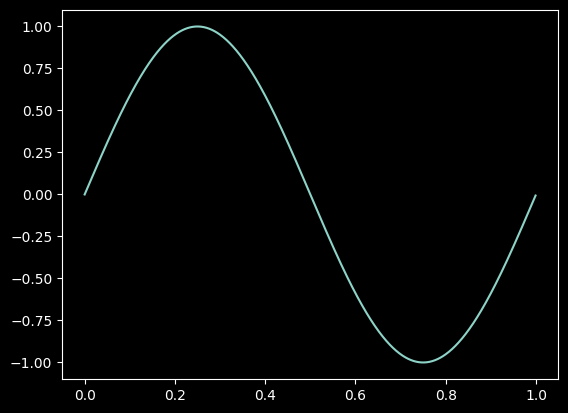

In [60]:
from nnfs.datasets import sine_data
nnfs.init()

X, y = sine_data()
plt.plot(X,y)
plt.show()

## Linear Activation Function

In [61]:
class Activation_Linear:
    
    #forward pass
    def forward(self, inputs):
        #remember values
        self.inputs = inputs
        self.output = inputs
        
    #backward pass
    def backward(self, dvalues):
        #derivative is 1
        #1 * dvalues = dvalues
        self.dinputs = dvalues.copy()

## Mean Square Error (MSE) Loss Class L2
MSE is used with regression models for loss calculation

In [62]:
class Loss_MeanSquaredError(Loss):
    
    #forward pass
    def forward(self, y_pred, y_true):
        #calculate loss per sample
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)
        
        #return losses
        return sample_losses
    
    #backward pass
    def backward(self, dvalues, y_true):
        #number of samples
        num_samples = len(dvalues)
        
        #number of outputs in every sample
        #use first sample to count
        num_outputs = len(dvalues[0])
        
        #gradient on values
        self.dinputs = -2 * (y_true - dvalues) / num_outputs
        #normalize gradient
        self.dinputs = self.dinputs / num_samples

## Mean Absolute Error (MAE) Loss Class L1

In [63]:
class Loss_MeanAbsoluteError(Loss):
    
    #forward pass
    def forward(self, y_pred, y_true):
        #calculate loss per sample
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)
        
        #return losses
        return sample_losses
    
    #backward pass
    def backward(self, dvalues, y_true):
        
        #number of samples
        num_samples = len(dvalues)
        #number of outputs per sample
        #use first output sample to calculate
        num_outputs = len(dvalues[0])
        
        #calculate gradient
        self.dinputs = np.sign(y_true - dvalues) / num_outputs
        #normalize gradient
        self.dinputs = self.dinputs / num_samples

## Regression Model

In [109]:
import time
import matplotlib
matplotlib.use('TkAgg')

#create dense layer with 1 input feature and 64 output values
dense1 = Layer_Dense(1,64)

#create ReLU activation (to be used with Dense Layer)
activation1 = ReLU_Activation()

#create 2nd dense layer with 64 input features
#as we take output from previous layer
#we output 64 values as there is 64 neurons in this layer
dense2 = Layer_Dense(64, 64)

#create ReLU activation activation
activation2 = ReLU_Activation()

#create 3rd dense layer with 64 input features
#we take output of previous layer and output 1
dense3 = Layer_Dense(64,1)

#create linear activation
activation3 = Activation_Linear()

#create loss function
loss_function = Loss_MeanSquaredError()

#create optimizer
optimizer = Optimizer_Adam(learning_rate=0.005, decay=1e-3)

#accuracy precision for accuracy calculation
#here we'll calculate this precision as a fraction of the standard deviation
#of all the ground truth values
#this fraction factor can be increased to create a more strict
#accuracy metric
#this means our training dataset should be as normal as possible as 
#std is less reliable with non-normal distributions
accuracy_precision = np.std(y) / 250


###### Plot Weights, biases, and model training #########
plt.ion() #enable interactive mode
fig = plt.figure()

#model training
ax1 = plt.subplot2grid((1,8),(0,0), rowspan=1, colspan=2)

#dense 1 weights and biases
ax2 = plt.subplot2grid((1,8),(0,2), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((1,8),(0,3), rowspan=1, colspan=1)

#dense2 weights & biases
ax4 = plt.subplot2grid((1,8),(0,4), rowspan=1, colspan=1)
ax5 = plt.subplot2grid((1,8),(0,5), rowspan=1, colspan=1)

#dense3 weights & biases
ax6 = plt.subplot2grid((1,8),(0,6), rowspan=1, colspan=1)
ax7 = plt.subplot2grid((1,8),(0,7), rowspan=1, colspan=1)

line1, = ax1.plot(X, y)
line2, = ax1.plot([0,1],[0,1])
########################################################


#train in loop
for epoch in range(10001):
    #perform a forward pass of our training data through 1st layer
    dense1.forward(X)

    #perform forward pass through activation function
    #takes output of first layer as input
    activation1.forward(dense1.output)

    #perform forward pass through 2nd dense layer
    #takes outputs of activation function
    #of first layer as inputs
    dense2.forward(activation1.output)

    #perform forward pass through activation function
    #takes output of 2nd dense layer as input
    activation2.forward(dense2.output)
    
    #perform pass through 3rd dense layer
    #takes outputs of activation function of 2nd dense layer
    dense3.forward(activation2.output)
    
    #perform forward pass through activation function
    #takes outputs of 3rd dense layer as inputs
    activation3.forward(dense3.output)
    

    #calculate data loss
    data_loss = loss_function.calculate(activation3.output, y)

    #calculate regulaization penalty
    regularization_loss = \
        loss_function.regularization_loss(dense1) + \
        loss_function.regularization_loss(dense2) + \
        loss_function.regularization_loss(dense3)

    #calculate overall loss
    loss = data_loss + regularization_loss

    #calculate accuracy from output of activation 2 and targets
    #caculated by taking absolute difference between targets and predictions
    #and compare if differences are lower than precision value
    preds = activation3.output
    accuracy = np.mean(np.abs(preds - y) < accuracy_precision)
    
        
    if not epoch % 100:
        #plot X vs preds
        line2.set_xdata(X)
        line2.set_ydata(preds)
        
        dense1_wgraph = np.rot90(dense1.weights.tolist(), k=3)
        dense1_bgraph = np.rot90(dense1.biases.tolist(), k=3)
        
        dense2_wgraph = np.rot90(dense2.weights.tolist(), k=3)
        dense2_bgraph = np.rot90(dense2.biases.tolist(), k=3)
        
        dense3_wgraph = dense3.weights.tolist()
        dense3_bgraph = np.rot90(dense3.biases.tolist(), k=3)
        
        ax2.imshow(dense1_wgraph, cmap='seismic')
        ax3.imshow(dense1_bgraph, cmap='seismic')
        ax4.imshow(dense2_wgraph, cmap='seismic')
        ax5.imshow(dense2_bgraph, cmap='seismic')
        ax6.imshow(dense3_wgraph, cmap='seismic')
        ax7.imshow(dense3_bgraph, cmap='seismic')
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        time.sleep(0.1)
        
        print(f'epoch: {epoch}, ' +
        f'acc: {accuracy:.3f}, ' +
        f'loss: {loss:.3f} (' +
        f'data_loss: {data_loss:.3f}, ' +
        f'reg_loss: {regularization_loss:.6f}), ' +
        f'lr: {optimizer.current_learning_rate}')

    #backward pass
    loss_function.backward(activation3.output, y)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    #update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()

epoch: 0, acc: 0.003, loss: 0.498 (data_loss: 0.498, reg_loss: 0.000000), lr: 0.005
epoch: 100, acc: 0.007, loss: 0.057 (data_loss: 0.057, reg_loss: 0.000000), lr: 0.004549590536851684
epoch: 200, acc: 0.196, loss: 0.001 (data_loss: 0.001, reg_loss: 0.000000), lr: 0.004170141784820684
epoch: 300, acc: 0.015, loss: 0.001 (data_loss: 0.001, reg_loss: 0.000000), lr: 0.003849114703618168
epoch: 400, acc: 0.021, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000000), lr: 0.0035739814152966403
epoch: 500, acc: 0.747, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000000), lr: 0.00333555703802535
epoch: 600, acc: 0.774, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000000), lr: 0.0031269543464665416
epoch: 700, acc: 0.810, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000000), lr: 0.002942907592701589
epoch: 800, acc: 0.820, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000000), lr: 0.0027793218454697055
epoch: 900, acc: 0.037, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000000), lr: 0.0026329647182727752
epoc

epoch: 8000, acc: 0.991, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000000), lr: 0.00055561729081009
epoch: 8100, acc: 0.994, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000000), lr: 0.0005495109352676119
epoch: 8200, acc: 0.990, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000000), lr: 0.0005435373410153278
epoch: 8300, acc: 0.993, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000000), lr: 0.0005376922249704269
epoch: 8400, acc: 0.995, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000000), lr: 0.0005319714863283328
epoch: 8500, acc: 0.991, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000000), lr: 0.0005263711969681019
epoch: 8600, acc: 0.971, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000000), lr: 0.0005208875924575476
epoch: 8700, acc: 0.991, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000000), lr: 0.0005155170636148056
epoch: 8800, acc: 0.867, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000000), lr: 0.0005102561485865905
epoch: 8900, acc: 0.992, loss: 0.000 (data_loss: 0.000, reg_loss: 0.000000)

In [110]:
#close interactive figure 
try:
    plt.close(fig)
except:
    pass

#switch back to inline mode
%matplotlib inline

In [111]:
#Model validation
#create test dataset
X_test, y_test = sine_data()

#perform forward pass of training data through this layer
dense1.forward(X)
    
#perform forward pass through activation function
#takes output of first dense layer
activation1.forward(dense1.output)
    
#perform forward pass through 2nd dense layer
#takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)
    
#perform forward pass through activation function
#takes the output of 2nd dense layer
activation2.forward(dense2.output)

dense3.forward(activation2.output)

activation3.forward(dense3.output)

#calculate the data loss
loss = loss_function.calculate(activation3.output, y_test)

#calculate Accuracy from output of activation2 and targets
#part in parenthesis returns a binary mask - array consisting of True/False values
#multiplying by 1 changes it into an array of 1s and 0s
accuracy_precision = np.std(y_test) / 250
preds = activation3.output
accuracy = np.mean(np.abs(preds - y) < accuracy_precision)

print(f'Validation, acc: {accuracy:.3f}, loss: {loss:.3f}')

Validation, acc: 0.987, loss: 0.000


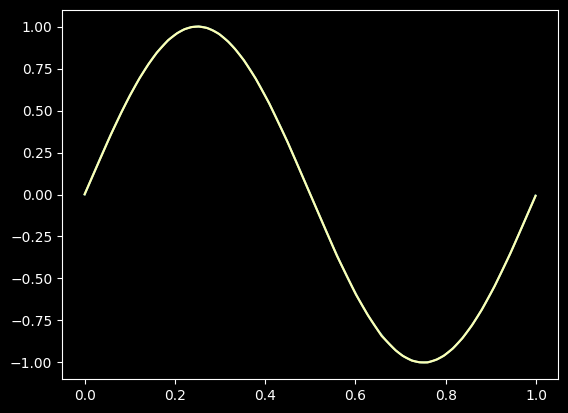

In [112]:
plt.plot(X_test,y_test)
plt.plot(X_test,preds)